<img src=https://play-lh.googleusercontent.com/NJa7lznYeODfNoxDCqCn8G0ZmAp__wYVvQ_zz4IB3_rKr99Clo2l4LxSgTyrtqMdHxA width="1000" height="200">

# **Kennzahl Prediction**

### WILLKOMMEN

Willkommen beim "***Prognose auf Tages- und Wochenebene***".der zu behandelte Datensatz enthält eine Zeitreihe der Kennzahl A von 3 Ländern. Ziel ist es eine Prognose auf Tages- und Wochenebene in einem Notebook oder Tool ihrer Wahl zu erstellen.
Jeweils am Montag werden neue Daten hinzugefügt und das Modell soll dann die Prognose für den
restlichen Monat berechnen.

# EINLEITUNG

1. Import Libraries
2. Exploratory Data Analysis (EDA) and Pre-Processing
3. Train Test Split
4. Scaling
5. Modeling
6. Evaluation on Test Data
7. Retrain and Forecast with Full
8. Forcasting
9. Saving

## Exploratory Data Analysis and Pre-processing


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
import datetime as dt

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,SimpleRNN,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
df=pd.read_excel("Junior_Data_Science_Input_data.xlsx",index_col="Datum", parse_dates=True)

In [ ]:
df

,Land,Monat,Woche,Kennzahl A
Datum,,,,
2010-11-05,Land A,201011,201044,217.730
2010-11-08,Land A,201011,201045,0.000
2010-11-09,Land A,201011,201045,80.550
2010-11-10,Land A,201011,201045,57.140
2010-11-11,Land A,201011,201045,277.990
...,...,...,...,...
2022-10-03,Land A,202210,202240,-127.860
2022-10-03,Land B,202210,202240,197973.720
2022-10-04,Land A,202210,202240,1667769.360


In [ ]:
df_A=df[df["Land"]=="Land A"]
# Ayni günlerde A B C olsa hangi ülkeyi aliriz ? 

In [ ]:
x=pd.DataFrame(df_A.groupby("Datum")[["Kennzahl A","Monat","Land","Woche"]].mean()) 

In [ ]:
x["Jahr"]=x.index.year
x["month"]=x.index.month
x["Day"]=x.index.day
x["Tagname"]=x.index.dayofweek
x["Datumm"]=x.index.date
x["Tagname2"]=x["Tagname"].replace({0:"Montag",1:"Dienstag",2:"Mittwoch",3:"Donnerstag",4:"Freitag",5:"Samstag",6:"Sonntag"})
x["Woche"]=x["Woche"].astype("str").apply(lambda x : x[4:6]).str.strip("").astype(int)
x.drop("Monat",axis=1,inplace=True)
x=x.rename(columns={'month':'Monat'})
x

,Kennzahl A,Woche,Jahr,Monat,Day,Tagname,Datumm,Tagname2
Datum,,,,,,,,
2010-11-05,217.730,44,2010,11,5,4,2010-11-05,Freitag
2010-11-08,0.000,45,2010,11,8,0,2010-11-08,Montag
2010-11-09,80.550,45,2010,11,9,1,2010-11-09,Dienstag
2010-11-10,57.140,45,2010,11,10,2,2010-11-10,Mittwoch
2010-11-11,277.990,45,2010,11,11,3,2010-11-11,Donnerstag
...,...,...,...,...,...,...,...,...
2022-09-30,521776.490,39,2022,9,30,4,2022-09-30,Freitag
2022-10-01,37403.763,39,2022,10,1,5,2022-10-01,Samstag
2022-10-02,144.475,39,2022,10,2,6,2022-10-02,Sonntag


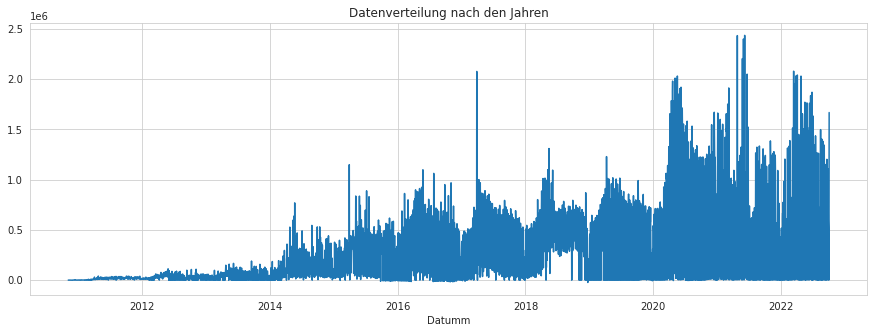

In [ ]:
y=x.groupby("Datumm")["Kennzahl A"].sum()
plt.figure(figsize=(15,5))
sns.lineplot(y.index,y.values)
plt.title("Datenverteilung nach den Jahren");

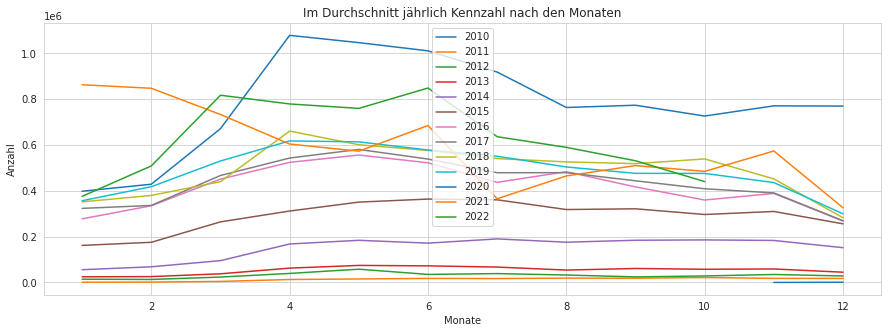

In [ ]:
Monatlich_nach_Jahren=x.groupby(["Jahr","Monat"])["Kennzahl A"].mean()
plt.figure(figsize=(15,5))
for i in Monatlich_nach_Jahren.index.levels[0]:
    plt.plot(Monatlich_nach_Jahren[i].index,Monatlich_nach_Jahren[i],label=i)

plt.legend()
plt.xlabel("Monate")
plt.ylabel("Anzahl")
plt.title("Im Durchschnitt jährlich Kennzahl nach den Monaten");

Ab 2016 steigen die Zahlen immer noch. Deswegen will ich die Daten, die ab  2016 eingegeben sind, durchschauen. Weil wir zu diesem Daten näher sind und ein Patern fassen. 

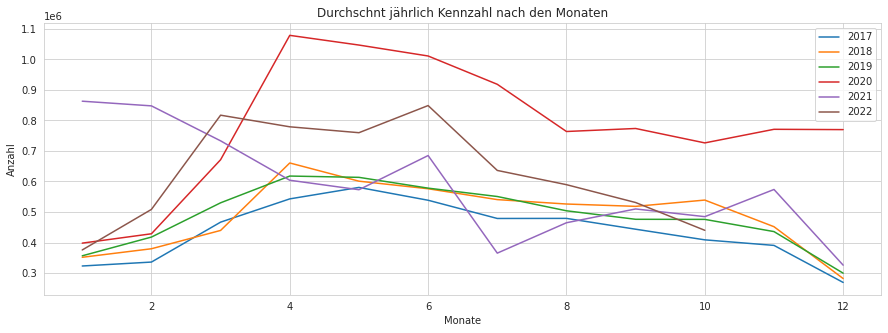

In [ ]:
Monatlich_nach_Jahren=x[x["Jahr"]>2016].groupby(["Jahr","Monat"])["Kennzahl A"].mean()
plt.figure(figsize=(15,5))
for i in Monatlich_nach_Jahren.index.levels[0]:
    plt.plot(Monatlich_nach_Jahren[i].index,Monatlich_nach_Jahren[i],label=i)

plt.legend()
plt.xlabel("Monate")
plt.ylabel("Anzahl")
plt.title("Durchschnt jährlich Kennzahl nach den Monaten");

Besonders ist ein Pattern ab 2019 auftreten. Aber man kan hier kein Pattern fassen.


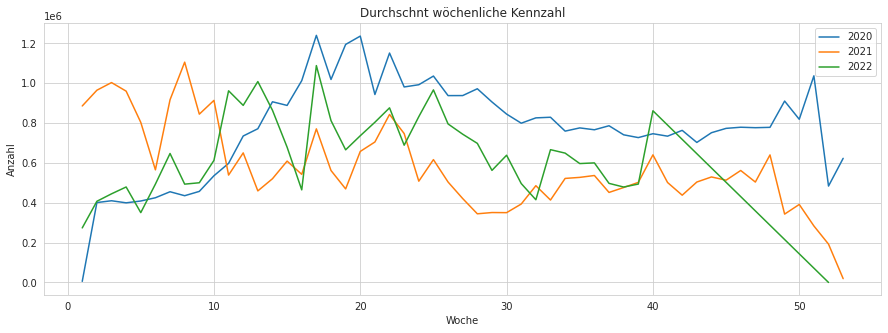

In [ ]:
Jahr_woche_Anzahl=x[x.index>="2020-01-04"].groupby(["Jahr","Woche"])["Kennzahl A"].mean()
plt.figure(figsize=(15,5))
for i in Jahr_woche_Anzahl.index.levels[0]:
    plt.plot(Jahr_woche_Anzahl[i].index,Jahr_woche_Anzahl[i],label=i)

plt.legend()
plt.xlabel("Woche")
plt.ylabel("Anzahl")
plt.title("Durchschnt wöchenliche Kennzahl");

Die Aussagen unter "Durchschnt wöchenliche Kennzahl" zeigen die Wochen im jeweiligen Jahr. Hier kann man sagen, ein Pattern zu fassen ist schwierig. 

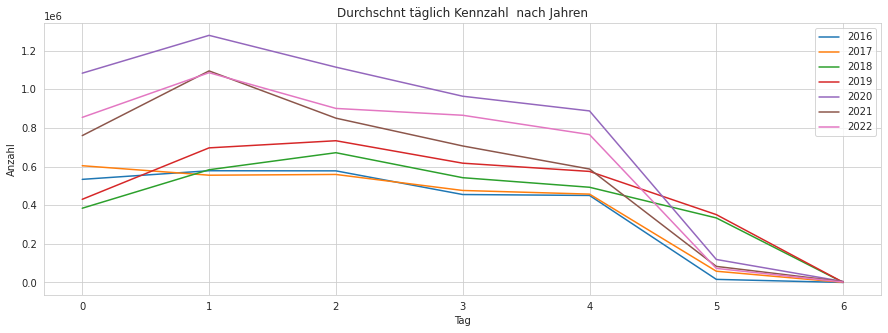

In [ ]:
Land_tag_Anzahl=x[x.index>="2016-01-04"].groupby(["Jahr","Tagname"])["Kennzahl A"].mean()
plt.figure(figsize=(15,5))
for i in Land_tag_Anzahl.index.levels[0]:
    plt.plot(Land_tag_Anzahl[i].index,Land_tag_Anzahl[i],label=i)

plt.legend()
plt.xlabel("Tag")
plt.ylabel("Anzahl")
plt.title("Durchschnt täglich Kennzahl  nach Jahren");

Die Daten durch Tagen gleichmäßig verteilt. Aber wie gemerkt gehen die am Wochenende runter. Das kann man auch ein Feature nutzen. Wochenende oder nicht ? Und wenn die aktuellen Daten Montags eingegeben werden, nutze ich Montag ebenso ein Feature. Montag oder nicht 

In [ ]:
x["is_Wochenende"]=x["Tagname"].apply(lambda x: 1 if x == 5 or x==6  else 0)

In [ ]:
x=x[x.index>="2020-01-06"]
x

,Kennzahl A,Woche,Jahr,Monat,Day,Tagname,Datumm,Tagname2,is_Wochenende
Datum,,,,,,,,,
2020-01-06,557722.160,2,2020,1,6,0,2020-01-06,Montag,0
2020-01-07,655371.880,2,2020,1,7,1,2020-01-07,Dienstag,0
2020-01-08,623832.600,2,2020,1,8,2,2020-01-08,Mittwoch,0
2020-01-09,533153.850,2,2020,1,9,3,2020-01-09,Donnerstag,0
2020-01-10,430277.910,2,2020,1,10,4,2020-01-10,Freitag,0
...,...,...,...,...,...,...,...,...,...
2022-09-30,521776.490,39,2022,9,30,4,2022-09-30,Freitag,0
2022-10-01,37403.763,39,2022,10,1,5,2022-10-01,Samstag,1
2022-10-02,144.475,39,2022,10,2,6,2022-10-02,Sonntag,1


In [ ]:
x=x.drop(["2022-10-04","2022-10-03"],axis=0)

In [ ]:
x.drop(["Woche","Jahr","Monat","Tagname","Tagname2","Datumm","Day"],axis=1,inplace=True)


In [ ]:
x

,Kennzahl A,is_Wochenende
Datum,,
2020-01-06,557722.160,0
2020-01-07,655371.880,0
2020-01-08,623832.600,0
2020-01-09,533153.850,0
2020-01-10,430277.910,0
...,...,...
2022-09-28,1108581.100,0
2022-09-29,596222.995,0
2022-09-30,521776.490,0


In [ ]:
B=x.copy()

In [ ]:
B

,Kennzahl A,is_Wochenende
Datum,,
2020-01-06,557722.160,0
2020-01-07,655371.880,0
2020-01-08,623832.600,0
2020-01-09,533153.850,0
2020-01-10,430277.910,0
...,...,...
2022-09-28,1108581.100,0
2022-09-29,596222.995,0
2022-09-30,521776.490,0


In [ ]:
A=x.copy()

In [ ]:
#A[(A.index.dayofweek==0) & (A.index>="2020-01-01")].head(1)

## Train Test Split

In [ ]:
test_size=A.reset_index()[A.reset_index()["Datum"]>="2021-10-04	"].shape[0]
train_size=A.shape[0]-test_size

In [ ]:
test_size,train_size

(364, 637)

In [ ]:
train,test=A.iloc[0:train_size],A.iloc[train_size : ]
print(train.shape[0],test.shape[0])

637 364


In [ ]:
A.corr()

,Kennzahl A,is_Wochenende
Kennzahl A,1.000,-0.727
is_Wochenende,-0.727,1.000


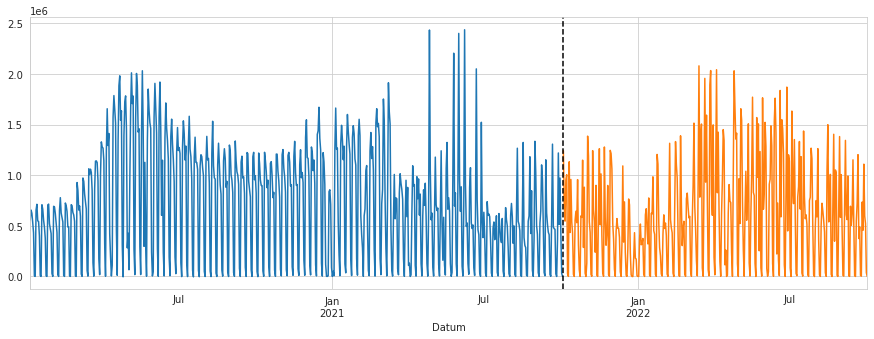

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
train["Kennzahl A"].plot(ax=ax,label="Train")
test["Kennzahl A"].plot(ax=ax,label="Test");
ax.axvline("2021-10-04",color="black", ls="--" );

### SCALING

Bei Scaling habe nicht eingriffen, weil alle columns zwischen 0 und 1 sind. Aber da wir Target-Column hier nutzen werden, müssen wir zu Target-Columns auch anwenden. Auch ich kann MinMax-Scaling anwenden. 

In [ ]:
f_scaler=RobustScaler()
target_scaler=RobustScaler()
# Eger sorulursa neden bunu kullandin ?


In [ ]:
train["Kennzahl A"]=target_scaler.fit_transform(train[["Kennzahl A"]])
test["Kennzahl A"]=target_scaler.transform(test[["Kennzahl A"]])

In [ ]:
def  create(X,y,time_steps):
  Xs,ys=[],[]
  for i in range(len(X)-time_steps):
    v=X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [ ]:
time_steps=7
X_train,y_train=create(train,train["Kennzahl A"], time_steps)
X_test,y_test=create(test,test["Kennzahl A"],time_steps)

# Modelling

In [ ]:
n_features=X_train.shape[2]

In [ ]:
model=Sequential()

model.add(Bidirectional(LSTM(units=118,input_shape=(time_steps,n_features))))

model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [ ]:
early=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

In [ ]:
model.fit(X_train,y_train,
          epochs=30,
          batch_size=1,
          validation_split=0.3,   
      callbacks=[early])

Epoch 1/30
441/441 [==============================] - 8s 9ms/step - loss: 0.1080 - val_loss: 0.1005
Epoch 2/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0677 - val_loss: 0.0951
Epoch 3/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0611 - val_loss: 0.1187
Epoch 4/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0571 - val_loss: 0.1007
Epoch 5/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0566 - val_loss: 0.1001
Epoch 6/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0538 - val_loss: 0.1136
Epoch 7/30
441/441 [==============================] - 3s 7ms/step - loss: 0.0566 - val_loss: 0.1158


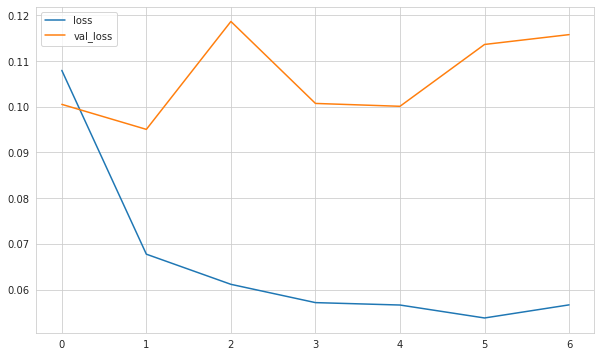

In [ ]:
pd.DataFrame(model.history.history).plot();

# Evaluation on Test Data

In [ ]:
def ev_metrics(act,pred):
  rmse = np.sqrt(mean_squared_error(act,pred))
  mae=mean_absolute_error(act,pred)
  mse=mean_squared_error(act,pred)
  score=r2_score(act,pred)
  return print("r2_score",score,"mae:",mse,"rmse:",rmse)

In [ ]:
y_pred=model.predict(X_test)

12/12 [==============================] - 2s 15ms/step


In [ ]:
ev_metrics(y_test,y_pred)

r2_score 0.5350422783681201 mae: 0.12060262263566886 rmse: 0.3472788830834217


In [ ]:
y_train_inv=target_scaler.inverse_transform(y_train.reshape(1,-1))
y_test_inv=target_scaler.inverse_transform(y_test.reshape(1,-1))
y_pred_inv=target_scaler.inverse_transform(y_pred)

In [ ]:
test_index=test.iloc[time_steps:].index
pred_test=pd.concat([pd.DataFrame(y_test_inv.reshape(-1,1)),
                     pd.DataFrame(y_pred_inv)], axis=1)
pred_test.columns=["test","prediction"]
pred_test.index=test_index
pred_test

,test,prediction
Datum,,
2021-10-11,1132176.780,931049.938
2021-10-12,433590.490,980599.625
2021-10-13,957430.890,650276.375
2021-10-14,538767.045,728982.625
2021-10-15,427987.665,571033.875
...,...,...
2022-09-28,1108581.100,695723.500
2022-09-29,596222.995,566219.625
2022-09-30,521776.490,444687.375


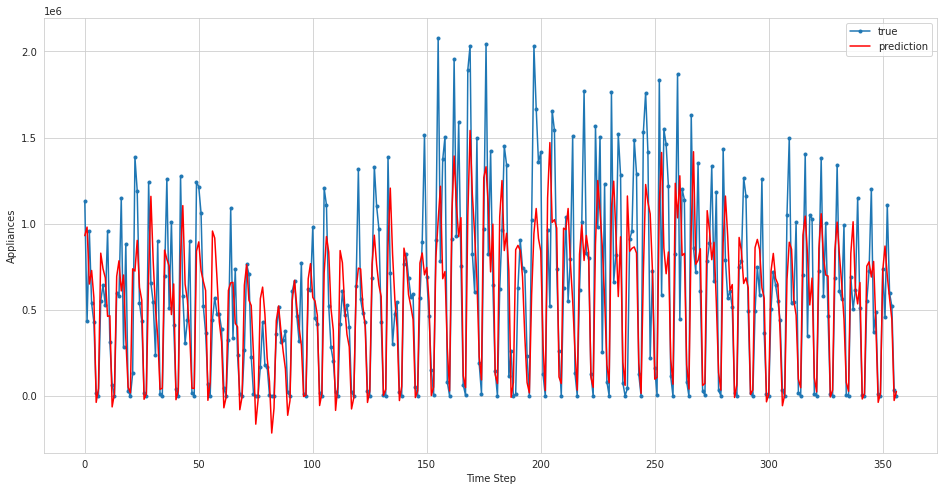

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(),marker=".",label="true")
plt.plot(y_pred_inv.flatten(),"r",label="prediction")
plt.ylabel("Appliances")
plt.xlabel("Time Step")
plt.legend();

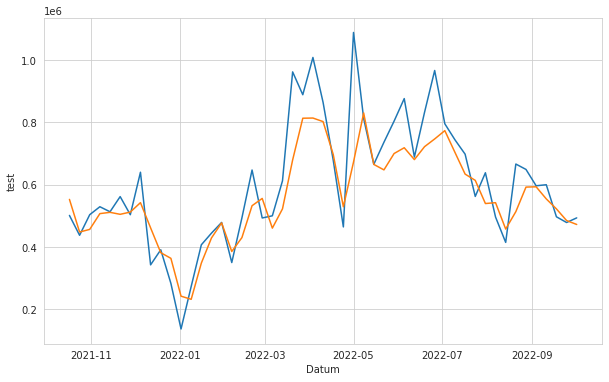

In [ ]:
a=pred_test.resample("W").mean()
sns.lineplot(x=a.index,y="test",data=a)
sns.lineplot(x=a.index,y="prediction",data=a);

# Second Way: After each prediction, result will be used for next prediction

In [ ]:
df_fake=test.iloc[:time_steps,1:]
df_fake

,is_Wochenende
Datum,
2021-10-04,0
2021-10-05,0
2021-10-06,0
2021-10-07,0
2021-10-08,0
2021-10-09,1
2021-10-10,1


In [ ]:
real=np.array(test.iloc[:time_steps,:1])
real.reshape((1,-1))[0]

array([ 0.54093659,  0.01993961, -0.13760727,  0.26084803,  0.30972496,
       -0.64377097, -0.67049677])

In [ ]:
df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1])).shape

(7, 1, 1)

In [ ]:
prediction_scaled=[]
first_eval_batch=train.values[-time_steps:]
current_batch=first_eval_batch.reshape((1,time_steps,n_features))
features= df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1]))

for i in range(time_steps):
  current_pred=model.predict(current_batch)
  prediction_scaled.append(current_pred[0])
  new=features[i][0].tolist()
  new.insert(0,current_pred[0][0])
  new=np.array(new).reshape(1,1,n_features)
  current_batch=np.append(current_batch[:,1:,:],new,axis=1)

1/1 [==============================] - 0s 18ms/step


In [ ]:
def ev_metrics(act,pred):
  rmse = np.sqrt(mean_squared_error(act,pred))
  mae=mean_absolute_error(act,pred)
  mse=mean_squared_error(act,pred)
  score=r2_score(act,pred)
  return print("r2_score",score,"mae:",mse,"rmse:",rmse)

In [ ]:
ev_metrics(real,prediction_scaled)

r2_score 0.43001114327917833 mae: 0.10791162935528002 rmse: 0.3284990553339233


In [ ]:
predictions=target_scaler.inverse_transform(prediction_scaled)
real=target_scaler.inverse_transform(real)

In [ ]:
com=pd.DataFrame(data=real,index=test.index[:time_steps],columns=["real"])
com["pred"]=predictions

In [ ]:
com

,real,pred
Datum,,
2021-10-04,1241112.790,716245.789
2021-10-05,707494.540,961984.453
2021-10-06,546131.055,708630.746
2021-10-07,954239.020,638474.084
2021-10-08,1004300.010,436624.576
2021-10-09,27705.425,-30854.349
2021-10-10,332.190,19684.108


# Retrain and Forecast with Full

In [ ]:
val_size=7
val=A.iloc[-val_size:]
full=A.iloc[:-val_size]
print(len(full),len(val))

994 7


In [ ]:
target_transform=RobustScaler()
train["Kennzahl A"]=target_transform.fit_transform(train[["Kennzahl A"]])
test["Kennzahl A"]=target_transform.transform(test[["Kennzahl A"]])

In [ ]:
X,y=create(full,full["Kennzahl A"],time_steps)

In [ ]:
model=Sequential()

model.add(Bidirectional(LSTM(units=118,input_shape=(time_steps,n_features))))

model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [ ]:
model.fit(X,y,epochs=30,batch_size=1)

Epoch 1/30
987/987 [==============================] - 17s 13ms/step - loss: 0.1161
Epoch 2/30
987/987 [==============================] - 8s 8ms/step - loss: 0.0935
Epoch 3/30
987/987 [==============================] - 7s 7ms/step - loss: 0.0926
Epoch 4/30
987/987 [==============================] - 6s 6ms/step - loss: 0.0909
Epoch 5/30
987/987 [==============================] - 5s 5ms/step - loss: 0.0899
Epoch 6/30
987/987 [==============================] - 7s 7ms/step - loss: 0.0880
Epoch 7/30
987/987 [==============================] - 5s 6ms/step - loss: 0.0884
Epoch 8/30
987/987 [==============================] - 5s 5ms/step - loss: 0.0877
Epoch 9/30
987/987 [==============================] - 5s 5ms/step - loss: 0.0885
Epoch 10/30
987/987 [==============================] - 6s 6ms/step - loss: 0.0886
Epoch 11/30
987/987 [==============================] - 5s 6ms/step - loss: 0.0868
Epoch 12/30
987/987 [==============================] - 6s 6ms/step - loss: 0.0848
Epoch 13/30
987/987 [==

# Forecasting

In [ ]:
df

,Land,Monat,Woche,Kennzahl A
Datum,,,,
2010-11-05,Land A,201011,201044,217.730
2010-11-08,Land A,201011,201045,0.000
2010-11-09,Land A,201011,201045,80.550
2010-11-10,Land A,201011,201045,57.140
2010-11-11,Land A,201011,201045,277.990
...,...,...,...,...
2022-10-03,Land A,202210,202240,-127.860
2022-10-03,Land B,202210,202240,197973.720
2022-10-04,Land A,202210,202240,1667769.360


In [ ]:
reel=np.array(val.iloc[:,:1])
reel.reshape((1,-1))[0]

array([ 0.04657279, -0.22534424,  0.41153957, -0.08870012, -0.16138579,
       -0.63430202, -0.67068004])

In [ ]:
forecast=[]
first_eval_batch=train.values[-time_steps:]
current_batch=first_eval_batch.reshape((1,time_steps,n_features))
features= df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1]))

for i in range(time_steps):
  current_pred=model.predict(current_batch)
  forecast.append(current_pred[0])
  new=features[i][0].tolist()
  new.insert(0,current_pred[0][0])
  new=np.array(new).reshape(1,1,n_features)
  current_batch=np.append(current_batch[:,1:,:],new,axis=1)

1/1 [==============================] - 0s 17ms/step


In [ ]:
ev_metrics(reel.reshape((1,-1))[0],forecast)

r2_score 0.5673760484089438 mae: 0.05306412852408217 rmse: 0.23035652481334704


In [ ]:
forecast1=target_transform.inverse_transform(np.array(forecast).reshape(1,-1))
forecast_index=pd.date_range(start="2022-10-04",periods=time_steps,freq="D")
forecast_df=pd.DataFrame(data=forecast1.reshape(-1,1),index=forecast_index,columns=["forecast"])
forecast_df

,forecast
2022-10-04,0.066
2022-10-05,0.275
2022-10-06,0.073
2022-10-07,-0.032
2022-10-08,-0.181
2022-10-09,-0.610
2022-10-10,-0.630


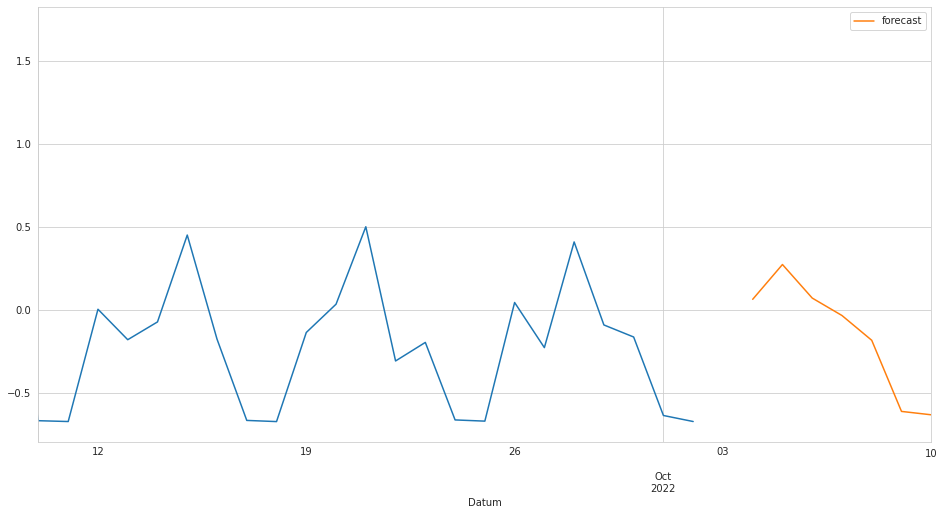

In [ ]:
ax=A["Kennzahl A"].plot()
forecast_df.plot(ax=ax,figsize=(16,8))
plt.xlim("2022-09-10","2022-10-10");

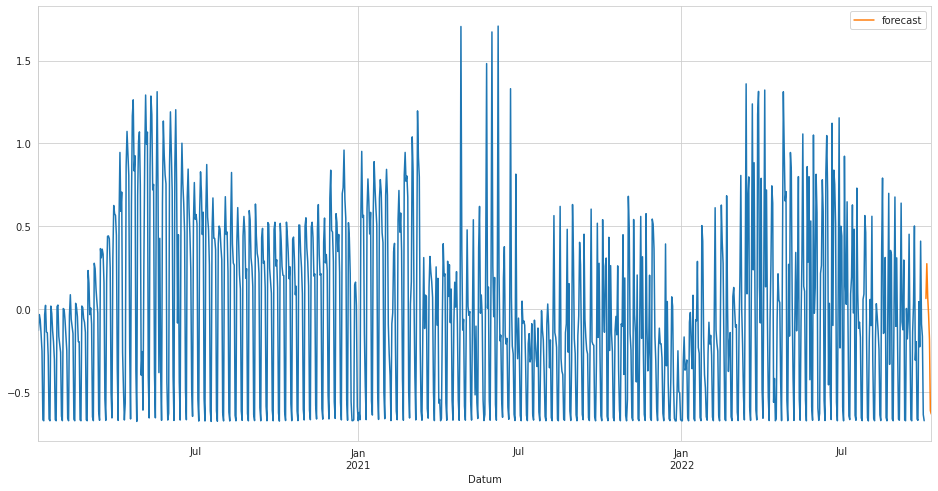

In [ ]:
ax = A["Kennzahl A"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

## Saving

In [ ]:
import pickle

In [ ]:
pickle.dump(target_transform,open("scaler_final","wb"))

In [ ]:
model.save("my_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_final=load_model("my_model.h5")
scaler_final=pickle.load(open("scaler_final","rb"))

## Prediction 

In [ ]:
sample=B.iloc[-7:-6,:]

In [ ]:
sample

,Kennzahl A,is_Wochenende
Datum,,
2022-09-26,734772.920,0


In [ ]:
scaler_final.transform(sample[["Kennzahl A"]])

array([[734772.92]])

In [ ]:
model_final.predict(sample)